## Домашнее задание

1. Измените функцию predict(w, X) так, чтобы можно было подать порог для классификации.
2. Подберите аргументы функции optimize для логистической регрессии таким образом, чтобы log loss был минимальным.
3. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.
4. Постройте кривую оббучения (значение оценки потерь от итерации) для примеров из тренировочной и тестовой выборки
5. Оцените результаты и сделайте выводы. 
6. Попробуйте ответить на вопросы: Могла ли модель переобучиться? На каком шаге это произошло? Почему?



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

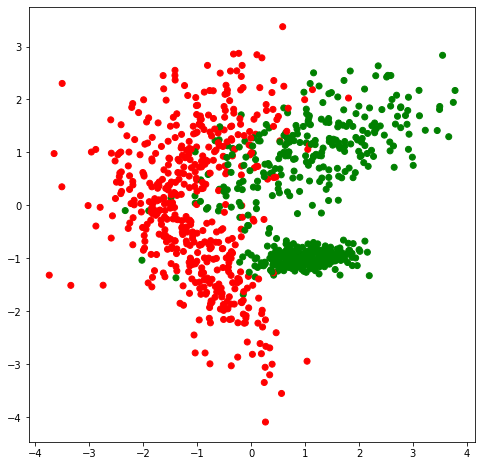

In [3]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=110)
# 

#classes = datasets.make_blobs(n_samples=1000,centers = 2, cluster_std = 1., random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue','green'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)
plt.show()

Далее разделим выборку на обучающую и тестовую. При реальной работе, если нет специфических требований по сохранению порядка выборки, ее полезно перемешивать, так как данные в ней могут быть каким-либо образом отсортированы. Это может негативно сказаться на процессе обучения.

In [4]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.9
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (900, 2)
Размер массива признаков тестовой выборки (100, 2)
Размер массива ответов для обучающей выборки (900,)
Размер массива ответов для тестовой выборки (100,)


In [5]:
 y_test

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1])

Далее транспонируем матрицы данных, так как нам удобнее работать со строками

In [6]:
X_train_tr = X_train.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_test_tr = X_test.transpose()
y_test_tr = y_test.reshape(1, y_test.shape[0])

In [7]:
def log_loss(w, X, y):
    m = X.shape[1]

    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(w.T, X))
    
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    loss = np.squeeze(loss)
    grad = 1.0 / m * np.dot(X, (A - y).T)
    
    return loss, grad

Реализуем градиентный спуск

In [8]:
def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []
    
    for i in range(n_iterations):        
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad

        losses.append(loss)
        
    return w, losses

и функцию для выполнения предсказаний

In [9]:
#min_value - порог классификации, минимальное значение вероятности, 
#при котором результат будет считаться истиной
def predict(w, X, min_value):
    
    m = X.shape[1]
    
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
#     За порог отнесения к тому или иному классу примем вероятность 0.5
    for i in range(A.shape[1]):
        if (A[:,i] > min_value): 
            y_predicted[:, i] = 1
        elif (A[:,i] <= min_value):
            y_predicted[:, i] = 0
    
    return y_predicted

In [11]:
# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[0], 1))-1

list_n = [10,20,50,100,500]
list_eta = [0.01, 0.1, 0.55, 1, 10, 100]
for i in range(len(list_n)):
    for j in range(len(list_eta)):
        n_iterations = list_n[i]
        eta = list_eta[j]

        w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

        print(f"/n Количество итераций: {n_iterations}, eta: {eta}, Значение функции Logloss : {losses[-1]}")

        

/n Количество итераций: 10, eta: 0.01, Значение функции Logloss : 1.467012268524034
/n Количество итераций: 10, eta: 0.1, Значение функции Logloss : 0.9974586378661175
/n Количество итераций: 10, eta: 0.55, Значение функции Logloss : 0.3680837972088101
/n Количество итераций: 10, eta: 1, Значение функции Logloss : 0.3076248615753449
/n Количество итераций: 10, eta: 10, Значение функции Logloss : 0.2886231129946841
/n Количество итераций: 10, eta: 100, Значение функции Logloss : nan
/n Количество итераций: 20, eta: 0.01, Значение функции Logloss : 1.400978617555435
/n Количество итераций: 20, eta: 0.1, Значение функции Logloss : 0.650643603890475
/n Количество итераций: 20, eta: 0.55, Значение функции Logloss : 0.3027127414281867
/n Количество итераций: 20, eta: 1, Значение функции Logloss : 0.27939337624599875
/n Количество итераций: 20, eta: 10, Значение функции Logloss : 0.2683474830436514
/n Количество итераций: 20, eta: 100, Значение функции Logloss : 0.4570178428483824
/n Количест

<ipython-input-7-885c956a0492>:7: RuntimeWarning: divide by zero encountered in log
  loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
<ipython-input-7-885c956a0492>:7: RuntimeWarning: invalid value encountered in multiply
  loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))


/n Количество итераций: 100, eta: 0.01, Значение функции Logloss : 0.9600518852212109
/n Количество итераций: 100, eta: 0.1, Значение функции Logloss : 0.30907379786222344
/n Количество итераций: 100, eta: 0.55, Значение функции Logloss : 0.26892572877936516
/n Количество итераций: 100, eta: 1, Значение функции Logloss : 0.2682963172172171
/n Количество итераций: 100, eta: 10, Значение функции Logloss : 0.26826588530816026
/n Количество итераций: 100, eta: 100, Значение функции Logloss : nan
/n Количество итераций: 500, eta: 0.01, Значение функции Logloss : 0.3798072725195646
/n Количество итераций: 500, eta: 0.1, Значение функции Logloss : 0.26925248714053246
/n Количество итераций: 500, eta: 0.55, Значение функции Logloss : 0.2682658858262941
/n Количество итераций: 500, eta: 1, Значение функции Logloss : 0.2682658853081605
/n Количество итераций: 500, eta: 10, Значение функции Logloss : 0.26826588530816026
/n Количество итераций: 500, eta: 100, Значение функции Logloss : nan


Минимальное значение функции LogLoss было найдено при гиперпараметрах: Количество итераций: 50, eta: 10

In [13]:
n_iterations=50
eta= 10
w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)
y_predicted_test = predict(w, X_test_tr, 0.5)
y_predicted_train = predict(w, X_train_tr, 0.5)

In [18]:
# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)
print(f"-----------------------------------")
print(f"Количество итераций: {n_iterations}, eta: {eta}")
print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

        


-----------------------------------
Количество итераций: 50, eta: 10
Итоговый вектор весов w: [[ 2.87020352e+00]
 [-1.41567142e-03]]
Точность на обучающей выборке: 89.111
Точность на тестовой выборке: 89.000


In [17]:
#рассчитаем матрицу ошибок:
conf_matrix = pd.crosstab((y_predicted_test[0]), y_test_tr[0])
print(f'Матрица ошибок:\n {conf_matrix}')
tp = conf_matrix[0][0]
fp = conf_matrix[0][1]
tn = conf_matrix[1][1]
fn = conf_matrix[1][0]
        
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
print(f"Точность = {precision}, полнота = {recall},")
print(f"F1 = {f1}")

Матрица ошибок:
 col_0   0   1
row_0        
0.0    47   3
1.0     8  42
Точность = 0.8545454545454545, полнота = 0.94,
F1 = 0.8952380952380952


Строим кривую обучения (значение оценки потерь от итерации) для примеров из тренировочной и тестовой выборки

In [25]:
w_test, losses_test = optimize(w0, X_test_tr, y_test_tr, n_iterations, eta)

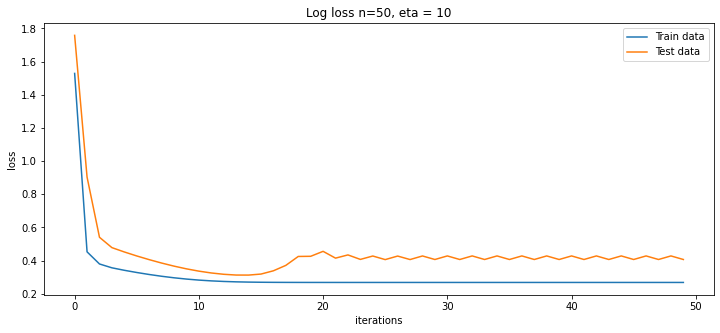

In [31]:
plt.figure(figsize = (12,5))
plt.title(f'Log loss n={n_iterations}, eta = {eta}')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), losses, )
plt.plot(range(len(losses_test)), losses_test)
plt.legend(['Train data','Test data'])

Видим на графике, что на тестовой выборке значение функции потерь от итерраций начинает увеличиваться примерно на 15 иттерации, при этом значение функции потерь на тренировочной выборке продолжает уменьшаться. Можно сделать вывод, что в этой точке модель начинает переобучаться.
